# Investigating Earthquakes from 1900~ 2016
### Keenan Zucker and James Jang

This notebook aims to explore the iterations we went through when working with Earthquake data and trying to come up with an interesting story. We started with data exploration, before moving into generating a model to fit our data. Upon visualizing those results, we realized it was not a particularily interesting story, so we transitioned to focusing on just California. We then looked at Kernel Density to create predictions of the probabilities of what type of earthquake would hit a given latitude and longitude spot

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV

import re

%matplotlib inline

In [3]:
quakes = pd.read_csv("./downloaded/data.csv")

### Initial Data Exploration

We explored the data individually and accumulated some of the important information we found with explanation and our thought process

Put the magnitude classification graph
depth classification graph

basemap - keenan marked with magnitude
add both code for the whole thing and just comment one of them out

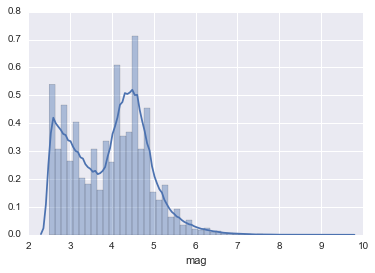

In [42]:
sns.distplot(quakes.mag)

### Magnitude Graphing
We used the an earthquake magnitude classification system shown [HERE](http://www.geo.mtu.edu/UPSeis/magnitude.html). After looking at our dataset, we decided to add a classification called 'tiny' that encompassed anything under a magnitude of 3, sice there was a significant chunk of data that was that small. We then used a barplot to observe what our data looked like.


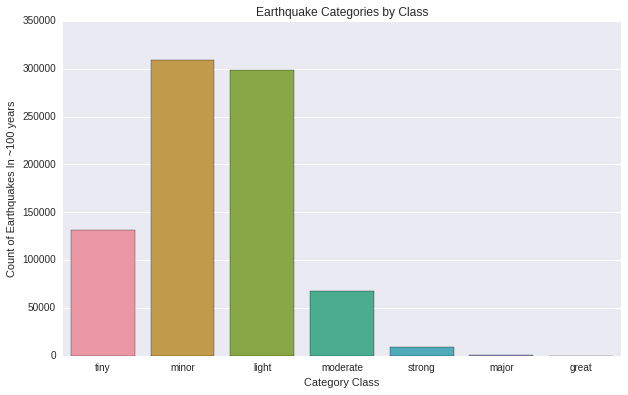

In [4]:
tiny = len(quakes[(quakes.mag < 3)])
minor = len(quakes[(quakes.mag < 4)])
light = len(quakes[(quakes.mag >= 4) & (quakes.mag < 5)])
moderate = len(quakes[(quakes.mag >= 5) & (quakes.mag < 6)])
strong = len(quakes[(quakes.mag >= 6) & (quakes.mag < 7)])
major = len(quakes[(quakes.mag >= 7) & (quakes.mag < 8)])
great = len(quakes[(quakes.mag >= 8)])

names=['tiny', 'minor', 'light', 'moderate', 'strong', 'major', 'great']
counts=[tiny, minor, light, moderate, strong, major, great]

plt.figure(figsize=(10,6))

sns.barplot(names, counts)
sns.plt.title("Earthquake Categories by Class")
sns.axlabel("Category Class", "Count of Earthquakes In ~100 years")

### Depth Graphing

We also wanted to look into depth of the earthquakes in a classification system [HERE](http://earthquake.usgs.gov/learn/topics/seismology/determining_depth.php) that used three categories, shallow intermediate and deep. We then used a bargraph again to visualize the data

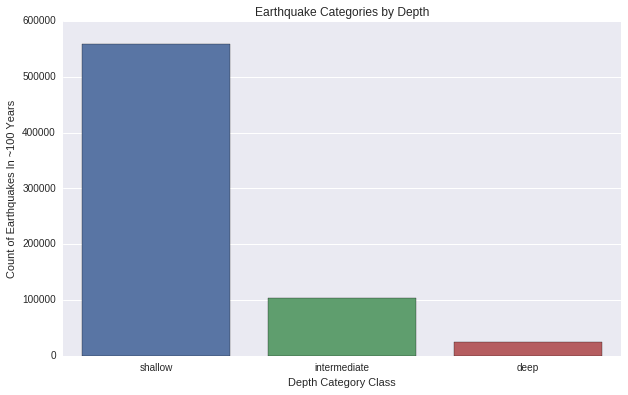

In [5]:
shallow = len(quakes[quakes.depth < 70])
intermediate = len(quakes[(quakes.depth >= 70) & (quakes.depth < 300)])
deep = len(quakes[quakes.depth >= 300])

names = ['shallow', 'intermediate', 'deep']
counts = [shallow, intermediate, deep]

plt.figure(figsize=(10,6))
sns.barplot(names, counts)
sns.plt.title("Earthquake Categories by Depth")
sns.axlabel("Depth Category Class", "Count of Earthquakes In ~100 Years")

### Basemap Visualization

We used a package called basemap to plot all of our points onto the globe. This looked pretty cool, as it basically mapped out most of the faultlines, as there are clearly areas, like the mid-atlantic ridge, that show a clear fault line. 

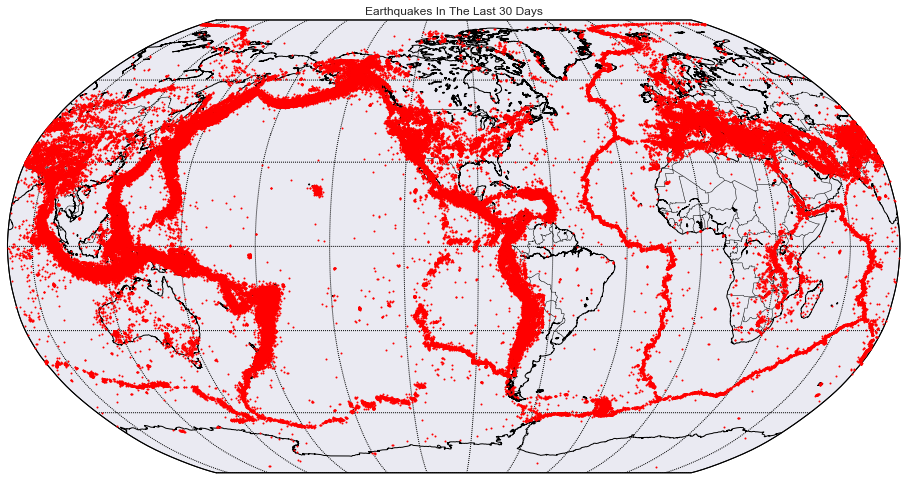

In [47]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(16,12))

my_map = Basemap(projection='robin', lat_0=0, lon_0=-100,
              resolution='l', area_thresh=1000.0)

lats = np.array(quakes.latitude)
longs = np.array(quakes.longitude)
mags = np.array(quakes.mag)
# print lats

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))

x,y = my_map(longs, lats)
my_map.plot(x, y, 'ro', markersize=2.0)
    
plt.title('Earthquakes In The Last 30 Days')
plt.show()

We then wanted to see where the larger earthquakes were located, so we used a function to use a different color to plot each of the points based off of magnitude. My computer couldn't handle plotting all 650,000 points with all of the different colors, so I limited it to a 10% sample of the data. 

In [6]:
def get_marker_color(magnitude):
    if magnitude < 3.0:
        return ('wo') # tiny
    elif magnitude < 4.0:
        return ('go') # minor
    elif magnitude < 5.0:
        return ('yo') # light
    elif magnitude < 5.0:
        return ('mo') # moderate
    elif magnitude < 6.0:
        return ('ro') # strong
    elif magnitude < 7.0:
        return ('ko') # major
    else:
        return ('ko') # great
    

In [7]:
quakes = pd.read_csv("./downloaded/data.csv")
quakes["color"] = quakes["mag"].apply(get_marker_color)


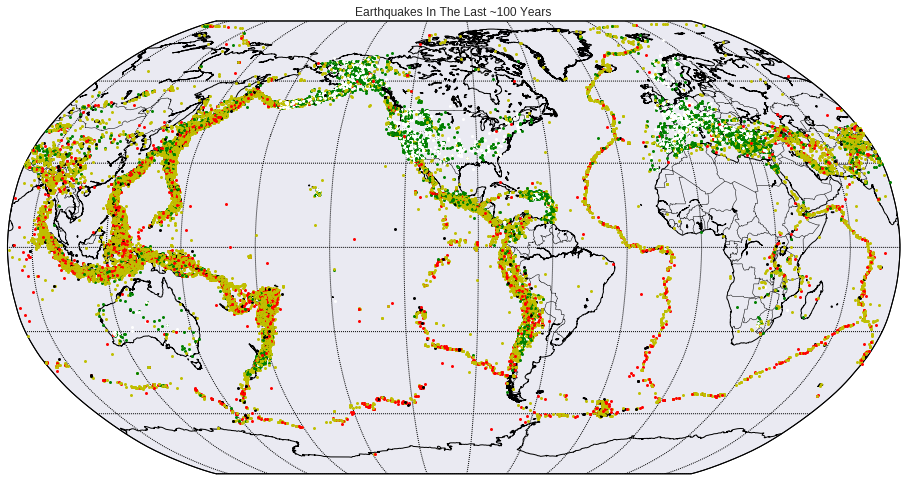

In [8]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(16,12))
quakes = quakes.sample(frac=0.1)


my_map = Basemap(projection='robin', lat_0=0, lon_0=-100,
              resolution='l', area_thresh=1000.0)

lats = np.array(quakes.latitude)
longs = np.array(quakes.longitude)
mags = np.array(quakes.mag)
colors = np.array(quakes.color)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))

for lon, lat, mag, col in zip(longs, lats, mags, colors):
    x,y = my_map(lon, lat)
    my_map.plot(x, y, col, markersize=3)
    
plt.title('Earthquakes In The Last ~100 Years')
plt.show()

### Models

Only looked at logistic and random forest classifer

add more models?

In [118]:
quakes = pd.read_csv("./downloaded/data.csv")

logistic = LogisticRegression()
random = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)

models = {'Logistic': logistic, 'RandomForest': random}

Helper functions to help us iterate

In [119]:
def cross_validate(model, X, y, cv=3):
    return cross_validation.cross_val_score(model, X, y, cv=cv).mean()

def train_test_splitter(model, X, y, train_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    model.fit(X_train, y_train)
    return X_train, X_test, y_train, y_test, model

# iterates over all different models and print out their results of train_test_splitter
def test_models(models, X, y):
    for modelName, model in models.iteritems():
        print modelName
        X_train, X_test, y_train, y_test, model = train_test_splitter(model, X, y, train_size=0.5)
        print model.score(X_test, y_test)

### Data Cleaning/Feature Engineering

How we created magClassified
depth classified
year

explain how each addition of columns helped the score

trying to map lat long into something

In [134]:
# def magclassify(mag):
#     if mag < 4:
#         return 0
#     elif mag < 5:
#         return 1
#     elif mag < 6:
#         return 2
#     elif mag < 7:
#         return 3
#     elif mag < 8:
#         return 4
#     elif mag >= 8:
#         return 5
    
def magclassify(mag):
    if mag < 3:
        return 0
    elif mag < 4:
        return 1
    elif mag < 5:
        return 2
    elif mag < 6:
        return 3
    elif mag < 7:
        return 4
    elif mag < 8:
        return 5
    elif mag >= 8:
        return 6
    
# "minor" "light" "moderate" "strong" "major" "great"   

def classifyMagType(magType):
    duration = ["Md", "md"]
    local = ["ml"]
    shortPS = ["mb_lg", "lg", "mblg"]
    shortPeriodWave = ["mb"]
    twenty = ["ms", "ms_20"]
    moment = ["mi", "mwp"]
    energy = ["me"]
    
    mw = ["mw", "mwb", "mwc","mwr","mww"]
    magType = str(magType).lower()
    if magType in duration:
        return 0
    elif magType in local:
        return 1
    elif magType in shortPS:
        return 2
    elif magType in shortPeriodWave:
        return 3
    elif magType in twenty:
        return 4
    elif magType in moment:
        return 5
    elif magType in energy:
        return 6
    elif magType in mw:
        return 7
    else:
        return 8    

def depthClassify(depth):
    if depth <20:
        return 0
    elif depth <40:
        return 1
    elif depth <60:
        return 2
    elif depth <80:
        return 3 
    elif depth < 300:
        return 4
    elif depth <700:
        return 5
    else:
        return 6 
    
def parse_date(Dates):
    return int(Dates[0:4]), int(Dates[5:7]), int(Dates[8:10]), int(Dates[11:13])

In [135]:
def add_features():
    quakes["magClassified"] = quakes["mag"].apply(magclassify)
    quakes["depth"] = quakes["depth"].fillna(quakes["depth"].median())
    quakes["magTypeClassified"] =  quakes["magType"].apply(classifyMagType)
    quakes["year"] = quakes.time.apply(lambda x: parse_date(x)[0])
    quakes["month"] = quakes.time.apply(lambda x: parse_date(x)[1])
    quakes["hour"] = quakes.time.apply(lambda x: parse_date(x)[3])
    quakes["depthClassified"] = quakes.depth.apply(depthClassify)
    quakes["country"] = quakes.place.apply(lambda x: str(x).split(", ")[-1])

In [136]:
add_features()

In [76]:
predictors = ["latitude", "longitude", "depth", "year"]
test_models(models, quakes[predictors], quakes.magClassified)

RandomForest
0.80777270557
Logistic
0.695624832598


### Tuning

We looked into tuning our Random Forest Classifier as well, using GridSearchCV. We looked into tuning 3 of the parameters in the Random Forest, to try to get a better model without overfitting. This basically ran through the model fitting for each of the parameters passed in, an calculated which ones were the best. We then graphed the different outcomes so we could visualize the impact they were making

[mean: 0.79089, std: 0.00138, params: {'min_samples_leaf': 1}, mean: 0.79551, std: 0.00076, params: {'min_samples_leaf': 2}, mean: 0.80026, std: 0.00090, params: {'min_samples_leaf': 3}, mean: 0.80270, std: 0.00117, params: {'min_samples_leaf': 4}, mean: 0.80412, std: 0.00098, params: {'min_samples_leaf': 5}, mean: 0.80579, std: 0.00123, params: {'min_samples_leaf': 6}, mean: 0.80648, std: 0.00114, params: {'min_samples_leaf': 7}, mean: 0.80665, std: 0.00108, params: {'min_samples_leaf': 8}, mean: 0.80704, std: 0.00119, params: {'min_samples_leaf': 9}, mean: 0.80730, std: 0.00153, params: {'min_samples_leaf': 10}, mean: 0.80777, std: 0.00077, params: {'min_samples_leaf': 11}, mean: 0.80762, std: 0.00103, params: {'min_samples_leaf': 12}, mean: 0.80776, std: 0.00109, params: {'min_samples_leaf': 13}, mean: 0.80808, std: 0.00109, params: {'min_samples_leaf': 14}, mean: 0.80817, std: 0.00112, params: {'min_samples_leaf': 15}]


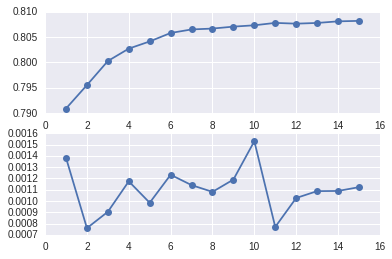

In [77]:
from sklearn.grid_search import GridSearchCV

parameters = [{'min_samples_leaf': np.arange(1,16)}]
model = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)

# predictors = ["latitude", "longitude", "depth", "magTypeClassified", "year", "month","hour"]
predictors = ["latitude", "longitude", "depth", "year"]

X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)

clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

print clf.grid_scores_

res = zip(*[(f1m, f1s.std(), p['min_samples_leaf']) 
            for p, f1m, f1s in clf.grid_scores_])

plt.subplot(2,1,1)
plt.plot(res[2],res[0],'-o')
plt.subplot(2,1,2)
plt.plot(res[2],res[1],'-o')
plt.show()

In [78]:
print clf.best_params_

{'min_samples_leaf': 15}


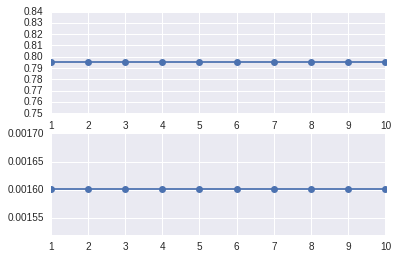

{'min_samples_split': 1}


In [20]:
parameters = [{'min_samples_split': np.arange(1,11)}]
model = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)

# predictors = ["latitude", "longitude", "depth", "magTypeClassified", "year", "month","hour"]
predictors = ["latitude", "longitude", "depth", "year"]

X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)


clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

res = zip(*[(f1m, f1s.std(), p['min_samples_split']) 
            for p, f1m, f1s in clf.grid_scores_])

plt.subplot(2,1,1)
plt.plot(res[2],res[0],'-o')
plt.subplot(2,1,2)
plt.plot(res[2],res[1],'-o')
plt.show()

print clf.best_params_

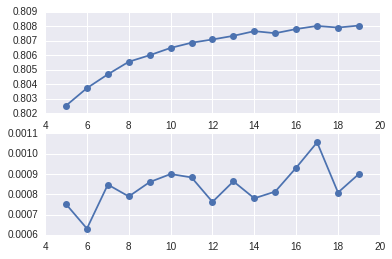

{'n_estimators': 19}


In [79]:
parameters = [{'n_estimators': np.arange(5,20)}]
model = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)

# predictors = ["latitude", "longitude", "depth", "magTypeClassified", "year", "month","hour"]
predictors = ["latitude", "longitude", "depth", "year"]

X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)


clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

res = zip(*[(f1m, f1s.std(), p['n_estimators']) 
            for p, f1m, f1s in clf.grid_scores_])

plt.subplot(2,1,1)
plt.plot(res[2],res[0],'-o')
plt.subplot(2,1,2)
plt.plot(res[2],res[1],'-o')
plt.show()

print clf.best_params_

In [80]:
predictors = ["latitude", "longitude", "depth", "year"]
# predictors = ["latitude", "longitude"]

logistic = LogisticRegression()


random = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)
models = {'Logistic': logistic, 'RandomForest': random}

print "Before Tuning: \n", test_models(models, quakes[predictors], quakes.magClassified)

random = RandomForestClassifier(random_state=1, n_estimators=19, min_samples_split=1, min_samples_leaf=15)
models = {'Logistic': logistic, 'RandomForest': random}
print "\n"
print "After Tuning: " , test_models(models, quakes[predictors], quakes.magClassified)

Before Tuning: 
RandomForest
0.808948888449
Logistic
0.695811158598
None


After Tuning:  RandomForest
0.810055199078
Logistic
0.695607364535
None


As shown, despite our grid search finding the 'best' parameters, the model score didn't really change in any significant way, maybe increasing by a small margin. We believe that the tuning wasn't enough to really push over the decisions in the tree to significant ways, therefore not affecting the model too heavily

### Anaylzing Model's performance

We wanted to see how our model was behaving. We were initially surprised by how well our model performed so we wanted to dissected its performance. 

randomforest does better because it classifies the lat long better

conclusion is that predictions were boring

In [40]:
from sklearn.metrics import classification_report

predictors = ["latitude", "longitude", "depth"]
X_train, X_test, y_train, y_test, model = train_test_splitter(random, quakes[predictors], quakes.magClassified)
y_pred = model.predict(X_test)

target_names = ["minor" "light" "moderate" "strong" "major" "great"]
# print(classification_report(y_test, y_pred, target_names=target_names))
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.88      0.88      0.88    154846
          1       0.71      0.87      0.79    149276
          2       0.43      0.06      0.11     33953
          3       0.46      0.04      0.07      4722
          4       0.00      0.00      0.00       650
          5       0.00      0.00      0.00        37

avg / total       0.76      0.78      0.75    343484



### Heatmap

We wanted to visualize our results using a heatmap. Basically, you could pass in a longitude and latitude, and it would create a grid around that point and see which type of earthquake would be most likely at each point around the quake, to see context. We found that the results were not very interesting, as the same type of earthquake was predicted all around the center point for basically all cases, even with the grid being a whole latitude or longitude degree seperation. This was pretty disappointing, but we learned that we needed to refocus our question to find out something more interesting or compelling. 

In [81]:

alg = RandomForestClassifier(random_state=1, n_estimators=19, min_samples_split=4, min_samples_leaf=10)

predictors = ["latitude", "longitude"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=10, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=19, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [82]:
lat = 42.00000
lon = -71.00000

center = [lon, lat]

def point_grid(center, size):
    points = []
    for i in range(0,size/2):
        center[0] -= 1
        center[1] -= 1
    Matrix = [[0 for x in range(size)] for x in range(size)] 
    
    for i in range(1,size + 1):
        for j in range(1, size + 1):
            Matrix[i-1][j-1] = ((center[0] + 1*j), (center[1] + 1*i))

    return Matrix
    
print point_grid(center, 5)


[[(-72.0, 41.0), (-71.0, 41.0), (-70.0, 41.0), (-69.0, 41.0), (-68.0, 41.0)], [(-72.0, 42.0), (-71.0, 42.0), (-70.0, 42.0), (-69.0, 42.0), (-68.0, 42.0)], [(-72.0, 43.0), (-71.0, 43.0), (-70.0, 43.0), (-69.0, 43.0), (-68.0, 43.0)], [(-72.0, 44.0), (-71.0, 44.0), (-70.0, 44.0), (-69.0, 44.0), (-68.0, 44.0)], [(-72.0, 45.0), (-71.0, 45.0), (-70.0, 45.0), (-69.0, 45.0), (-68.0, 45.0)]]


In [83]:
lat =37.352693
lon = -122.119904
center = [lon, lat]

def heatmap(quakesLoc):
    size = len(quakesLoc[0])
    Scores = [[0 for x in range(size)] for x in range(size)] 
    
    for i in range(0,size):
        for j in range(0,size):
            
            point = list(quakesLoc[i][j])
            score = max(alg.predict_proba(point)[0])
            Scores[i][j] = score
            
    sns.heatmap(Scores, annot=True, linewidths = 0.2)
    sns.plt.show()

def predmap(quakesLoc):
    size = len(quakesLoc[0])
    Predictions = [[0 for x in range(size)] for x in range(size)] 
    
    for i in range(0,size):
        for j in range(0,size):
            
            point = list(quakesLoc[i][j])
            predict = alg.predict(point)
            Predictions[i][j] = predict.item(0)
            
    sns.heatmap(Predictions, annot=True, linewidths = 0.2)
    sns.plt.show()


/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

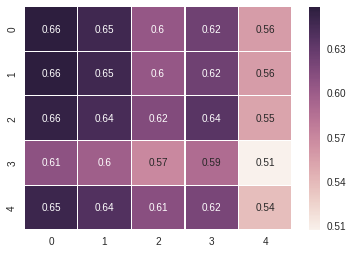

/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

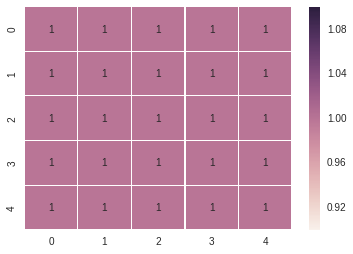

In [84]:
lat = 37
lon = -50

center = [lon, lat]

heatmap(point_grid(center,5))
predmap(point_grid(center,5))

As shown, the last heatmap shows a grid of all level 1 classifed earthquakes, which isn't particularily interesting or compelling

### Clustering using DBSCAN

link to DBSCAN

couldnt get what we wanted

### Transition to focusing on California

The predictions that we made with the world's earthquake data weren't all that interesting so we decided to focus on a specific region, California. California is known for many earthquake occurrences because San Andreas fault line goes through California.
Explain more about transitioning and what we wanted to figure out

kernal density and magClassified predictor to get the probability. multiply those values

In [144]:
print quakes.magClassified.unique()

[5 4 6 3 1 0 2]


In [145]:
quakes["country"] = quakes.place.apply(lambda x: str(x).split(", ")[-1])
print type(quakes.country.value_counts())
print quakes.country.value_counts()

<class 'pandas.core.series.Series'>
Indonesia                                  41514
Alaska                                     37083
CA                                         34014
Chile                                      33567
Japan                                      24219
California                                 21970
Papua New Guinea                           21812
Greece                                     19337
Mexico                                     17996
Philippines                                12731
Japan region                               11730
western Turkey                             11572
Fiji region                                10139
Kuril Islands                               8995
Argentina                                   8972
Vanuatu                                     8397
MX                                          8064
Russia                                      7881
Central Alaska                              7787
Tonga                            

In [152]:
ca = quakes[(quakes["country"] =="California")| (quakes["country"] =="CA")]


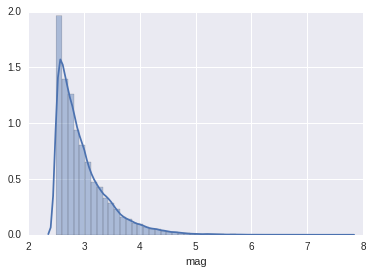

In [147]:
sns.distplot(ca.mag)

In [148]:
def get_marker_color(magnitude):
    if magnitude < 3.0:
        return ('wo') # tiny
    elif magnitude < 4.0:
        return ('go') # minor
    elif magnitude < 5.0:
        return ('yo') # light
    elif magnitude < 5.0:
        return ('mo') # moderate
    elif magnitude < 6.0:
        return ('ro') # strong
    elif magnitude < 7.0:
        return ('ko') # major
    else:
        return ('ko') # great
    

### Plotting California Earthquakes Based Off Magnitude

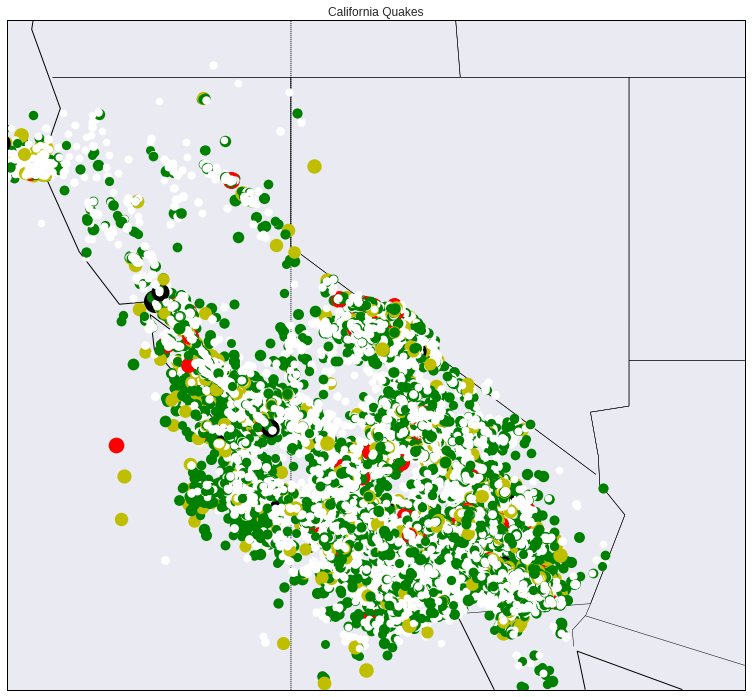

In [103]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(16,12))

my_map = Basemap(llcrnrlon=-125, llcrnrlat=31.2, urcrnrlon=-112, urcrnrlat=43, projection='cyl',
              resolution='c' )


lats = np.array(ca.latitude)
longs = np.array(ca.longitude)
mags = np.array(ca.mag)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.drawstates()
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))
# my_map.bluemarble()

for lon, lat, mag in zip(longs, lats, mags):
    x,y = my_map(lon, lat)
    marker_string = get_marker_color(mag)
    my_map.plot(x, y, marker_string, markersize=mag*3)
    
plt.title('California Quakes')
plt.show()

In [149]:
import seaborn as sns

def proba_graph(lat, lon, model):
    plt.figure(figsize=(12,8))
    point = [lat, lon]
    prediction = model.predict_proba(point)
    labels = ["tiny", "minor", "light", "moderate", "strong", "major"]    
    
    ax = sns.barplot(labels,prediction[0])
    total = float(len(prediction))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + 0.2, height+0.01, '%1.1f'%(height/total * 100 ),  fontsize=15, )
    
    sns.axlabel("Earthquake Classification Type", "Probability")
    plt.title("Earthquake Magnitude Probabilities")
    plt.ylim([0 ,1])
    
    plt.show()
    
    return prediction
    


In [150]:
predictors = ["latitude", "longitude"]
alg = RandomForestClassifier(random_state=1, n_estimators=19, min_samples_split=4, min_samples_leaf=15)
X_train, X_test, y_train, y_test = train_test_split(ca[predictors], ca.magClassified, train_size=.5)
alg.fit(X_train, y_train)
print alg.score(X_test, y_test)




0.646256073164


### Probability Graph

Using an inputted latitude and longitude, this graph predicts the type of earthquake that would occur, give that there *is* already and earthquake

/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


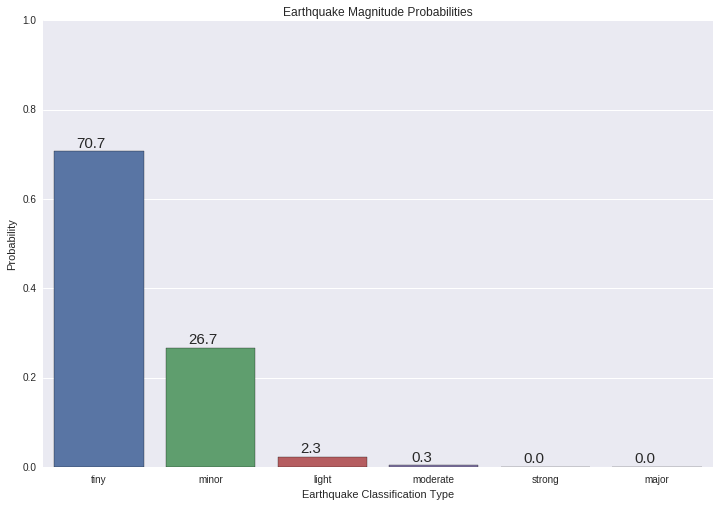

array([[ 0.70684113,  0.26680929,  0.022954  ,  0.00339559,  0.        ,
         0.        ]])

In [151]:
proba_graph(42, -71, alg)

kernal density plot here and 

when we multiply the kernal density plot value by the probably distribution then we should get the real probability

## Changing the World

I think our model and analysis has potential to change the world, but it is not quite there. We do have a relatively successful model that can predict which magnitude classification will occur given that there is an earthquake. However, the most difficult thing about this project is predicting if an earthquake at all will happen or not in a given spot or over a given timeframe. 

The next steps in the project would be to find a way to encode that when an earthquake *does* happen, it is also *not* happenning literally everywhere else on the globe. However, we don't want to drown out that one data point where there is a quake, so we would have to do some sort of weighting in order to account for that important point. We aren't sure exactly how we could do this, however. 

Clearly, if this problem were easier, then a tool like this would already exist and people would know more accurately when earthquakes would occur, rather than randomly. Because of the millions of dollars of damage that earthquakes cause, there is definitely a need here for this tool that would positively impact or change the world. 

## Learning Goals

I think the hardest part for us was refocusing our question. We kind of had a mid-project crisis when we realized that our model, although seemingly accurate, wasn't particularily interesting or useful. It was predicting minor or light earthquakes almost all of the time, which makes sense, but is also boring.

...